In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import dice_ml
from dice_ml import Dice
from dice_ml.utils import helpers

In [2]:
# Import dataset
data = pd.read_csv(r"data_cleaned.csv")

# Drop some columns
df = data.drop(columns=['Country', 'Timestamp']).reset_index(drop=True)
# mental_health_dummies = pd.get_dummies(df['Mental_Health_History'], prefix="Mental_Health_History")\
#     .drop(columns=["Mental_Health_History_No"])
df["Mental_Health_History"] = df['Mental_Health_History'].map({'No': 0, 'Maybe': 0, 'Yes': 1})
df = df.astype(float)

In [3]:
# Get mutable and immutable features
immutable_features = ['Australia_and_New_Zealand', 'Central_America', 'Eastern_Europe', 'Northern_America', 'Northern_Europe', 
                      'South_America', 'Southeastern_Asia', 'Southern_Africa', 'Southern_Asia', 'Southern_Europe', 'Western_Africa', 
                      'Western_Asia', 'Western_Europe', 'Female', 'family_history', 'Mental_Health_History']

mutable_features = [feature for feature in df.columns if feature not in immutable_features if feature != 'treatment']

In [4]:
# Get training and testing data
target = 'treatment'
X = df.drop(columns=[target])
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

F1 Score 0.7128540337327874
Accuracy 0.7133529503943725


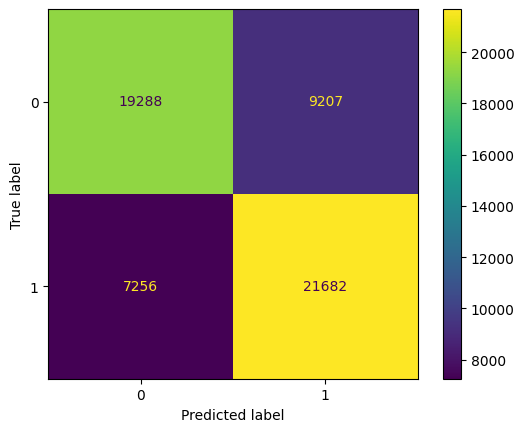

In [5]:
# Fit logistic regression
# clf = LogisticRegression(random_state=0, max_iter=1000)
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, y_pred)}")
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(values_format='d')
plt.show()

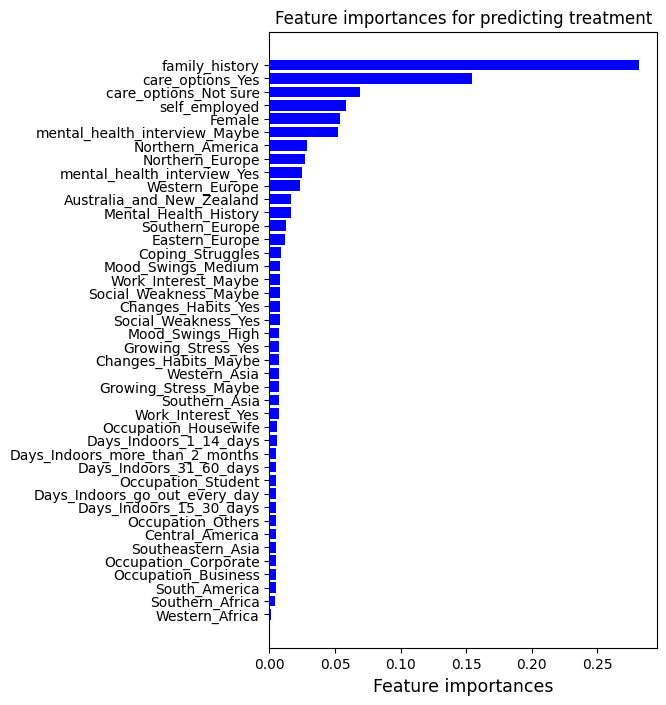

In [6]:
# Get feature importances
# feature_importances = clf.coef_.ravel()
feature_importances = clf.feature_importances_
features = X_train.columns
sorted_args = np.argsort(feature_importances)
colors = np.asarray(['b' if feature_importance >= 0 else 'r' for feature_importance in feature_importances])

# Plot them
fig, ax = plt.subplots(figsize=(5, 8))
plot = ax.barh(features[sorted_args], feature_importances[sorted_args],
        color=colors[sorted_args])
ax.set_xlabel("Feature importances", fontsize=12.5)
ax.set_title("Feature importances for predicting treatment")
plt.show()

In [7]:
# features_to_vary = ['self_employed', 'Coping_Struggles', 'Occupation_Business', 'Occupation_Corporate',
#                        'Occupation_Housewife', 'Occupation_Others', 'Occupation_Student',
#                        'Days_Indoors_1_14_days', 'Days_Indoors_15_30_days',
#                        'Days_Indoors_31_60_days', 'Days_Indoors_go_out_every_day',
#                        'Days_Indoors_more_than_2_months', 'Growing_Stress_Maybe',
#                        'Growing_Stress_Yes', 'Changes_Habits_Maybe', 'Changes_Habits_Yes',
#                        'care_options_Not sure', 'care_options_Yes']

In [12]:
def get_counterfactuals_from_model(X: pd.DataFrame, y: pd.Series, model, features_to_vary, outcome_name: str, 
                                   idx = None, n_samples: int = 1, random_state: int = 0, total_CFs: int = 5, 
                                   backend: str = "sklearn", continous_features = [], desired_class: str = "opposite") \
                                    -> dice_ml.counterfactual_explanations.CounterfactualExplanations:
    """
    Generates counterfactual explanations using the dice_ml package.

    Parameters
    ----------
    X: pd.DataFrame 
        A dataframe containing the train data
    y: pd.Series 
        A series containing the test data
    model: fitted sklearn model
        A fully trained model
    features_to_vary: list 
        A list of features in the train data which can be used to generate counterfactuals
    outcome_name: str
        Name of the target variable
    idx: Any, optional
        An integer index or list of integers from which to sample. If None, 
            a random sample is used (default is None)
    n_samples: int, optional
        Number of samples to be used from the training data (default is 1)
    random_state: int, optional
        seed for random index generator (default is 0)
    total_CFS: int, optional
        Total number of counterfactuals required (default is 5)
    backend: str, optional
        "TF1" ("TF2") for TensorFLow 1.0 (2.0), "PYT" for PyTorch implementations, 
            "sklearn" for Scikit-Learn implementations of standard
    continuous_features: list, optional
        List of features in X which are continuous (default is [])
    desired_class: str, optional
        Desired counterfactual class - can take 0 or 1. Default value
            is "opposite" to the outcome class of query_instance for binary classification.
    
    Returns
    -------
    cf: dice_ml.counterfactual_explanations.CounterfactualExplanations
        A CounterfactualExplanations object that contains the list of
            counterfactual examples per query_instance as one of its attributes.
    """
    # Prepare data for DiCE
    data_interface = dice_ml.Data(dataframe=pd.concat([X, y], axis=1), 
                         continuous_features=continous_features, outcome_name=outcome_name)
    
    # Prepare model for DiCE
    model_interface = dice_ml.Model(model=model, backend=backend)

    # Initialize DiCE
    dice = dice_ml.Dice(data_interface = data_interface, model_interface=model_interface)

    # Choose an instance for which you want counterfactuals
    if idx is None:
        query_instances = X.sample(n=n_samples, random_state=random_state)
    else:
        query_instances = X.iloc[idx]
    
    # Generate counterfactual explanations
    cf = dice.generate_counterfactuals(
        query_instances=query_instances,
        total_CFs=total_CFs,
        desired_class=desired_class,
        features_to_vary=features_to_vary
    )

    # Get differences between query instances and counterfactuals
    def get_differences(cf, query_instances):
        """Returns the differences between the query instances and counterfactuals."""
        # Store differences in array
        differences = []
        for cf_, query_instance in zip(cf.__dict__['_cf_examples_list'], query_instances.to_numpy()):
            # Multiply by -1 because we want to know the change from the original entry
            difference = (cf_.final_cfs_df.to_numpy()[:, :-1] - query_instance) * -1
            difference = np.where(difference == -0., 0, difference)
            differences.append(difference)
        return differences
    
    # Get differences as dataframes
    differences = get_differences(cf, query_instances)
    differences_as_df = []

    for difference in differences:
        difference_as_df = []
        for row_difference in difference:
            diff_as_df = pd.DataFrame({X.columns[i]:  [row_difference[i]] for i in range(len(X.columns))})
            difference_as_df.append(diff_as_df)
        differences_as_df.append(difference_as_df)
    
    return cf, differences_as_df

cf, differences = get_counterfactuals_from_model(X, y, clf, mutable_features, 'treatment', idx=list(range(3)), total_CFs=1)

100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


In [15]:
sample_row = differences[0][0]

plot_data = pd.DataFrame({
    'Feature': sample_row.columns,
    'Value': sample_row.values.flatten()
})
plot_data['Color'] = plot_data['Value'].map({-1: 'red', 1: 'blue'})

import plotly.express as px

# Create the horizontal bar plot
fig = px.bar(plot_data, x='Value', y='Feature', orientation='h', color='Color',
             title='Feature Values', labels={'Value': 'Value', 'Feature': 'Feature'},
             color_discrete_map={'red': 'red', 'blue': 'blue'})

# Update legend title and labels
fig.update_layout(
    legend_title_text='What to change'
)
fig.for_each_trace(lambda t: t.update(name={'red': '1 --> 0', 'blue': '0 --> 1'}[t.name]))

# Show the plot
fig.show()